In [1]:
'''
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
'''

"\nfrom google.colab import drive\ndrive.mount('/gdrive')\n%cd /gdrive\n"

In [2]:
import string
import re
import pickle
from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import unicodedata
import io
import os
import time

In [3]:
#path_to_file = '/content/fra1.txt'
#path_to_file = '/content/drive/My Drive/Colab Notebooks/fra1.txt'
path_to_file = 'indo-jawa.txt'

In [4]:
def unicode_to_acii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(w):
  w = unicode_to_acii(w.lower().strip())

# creating a space between a word and the punctuation following it
# eg: "he is a boy." => "he is a boy ." 
# Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
 
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  
# replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
# adding a start and an end token to the sentence
# so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
en_sentence = u"May I borrow this book?"
fr_sentence = u"Puis-je emprunter ce livre?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(fr_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> puis je emprunter ce livre ? <end>'


In [7]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [8]:
en, fr = create_dataset(path_to_file, None)
for s in range(9):
    print(en[s])
    print(fr[s])
    print('====')

<start> pergi . <end>
<start> tindak . <end>
====
<start> hai . <end>
<start> hai . <end>
====
<start> lari ! <end>
<start> mlayu ! <end>
====
<start> lari ! <end>
<start> mlayu ! <end>
====
<start> siapa ? <end>
<start> who ? <end>
====
<start> wow ! <end>
<start> wuh ! <end>
====
<start> api ! <end>
<start> geni ! <end>
====
<start> membantu ! <end>
<start> tulung ! <end>
====
<start> melompat . <end>
<start> mlumpat . <end>
====


In [9]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
# Try experimenting with the size of that dataset
num_examples = 99999
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
print(inp_lang)

In [13]:
# saving
with open('inp_lang.pickle', 'wb') as handle:
    pickle.dump(inp_lang, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('targ_lang.pickle', 'wb') as handle:
    pickle.dump(targ_lang, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)

In [14]:
print(max_length_inp, max_length_targ)

13 14


In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size = 0.1 )
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

89999 89999 10000 10000


In [16]:
print(input_tensor.shape)

(99999, 13)


In [17]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print(inp_lang.index_word[10])

tom


In [19]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[100])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[100])

Input Language; index to word mapping
1 ----> <start>
188 ----> banyu
2255 ----> nggambarake
1050 ----> cahya
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
195 ----> air
5725 ----> memantulkan
1275 ----> cahaya
3 ----> .
2 ----> <end>


In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 60
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 13), (64, 14)), types: (tf.int32, tf.int32)>


In [21]:
print(vocab_inp_size)
print(vocab_tar_size)

8428
8764


In [22]:
input_batch, target_batch = next(iter(dataset))
input_batch.shape, target_batch.shape

(TensorShape([64, 13]), TensorShape([64, 14]))

In [23]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    print('cuDNNGRU is Used')
    return CuDNNGRU(units, return_sequences=True, 
                           return_state=True, 
                           recurrent_initializer='glorot_uniform')
  else:
    print('GRU is used')
    return GRU(units, return_sequences=True, 
                      return_state=True, 
                      recurrent_activation='sigmoid', 
                      recurrent_initializer='glorot_uniform')

In [24]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = CuDNNGRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = BahdanauAttention(10)

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))
        

In [27]:
'''class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights
'''

"class Decoder(tf.keras.Model):\n  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):\n    super(Decoder, self).__init__()\n    self.batch_sz = batch_sz\n    self.dec_units = dec_units\n    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)\n    self.gru = tf.keras.layers.GRU(self.dec_units,\n                                   return_sequences=True,\n                                   return_state=True,\n                                   recurrent_initializer='glorot_uniform')\n    self.fc = tf.keras.layers.Dense(vocab_size)\n\n    # used for attention\n    self.attention = BahdanauAttention(self.dec_units)\n\n  def call(self, x, hidden, enc_output):\n    # enc_output shape == (batch_size, max_length, hidden_size)\n    context_vector, attention_weights = self.attention(hidden, enc_output)\n\n    # x shape after passing through embedding == (batch_size, 1, embedding_dim)\n    x = self.embedding(x)\n\n    # x shape after concatenation == (batch_size, 

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
cuDNNGRU is Used


In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [30]:
checkpoint_dir = './training_checkpointss'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [32]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss = total_loss + batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      print('Time taken for 1 batch {} sec\n'.format(time.time() - start))
  # saving (checkpoint) the model every 2 epochs
 # if (epoch + 1) % 2 == 0:
 #   checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.0528
Time taken for 1 batch 17.846041917800903 sec

Epoch 1 Batch 100 Loss 2.3312
Time taken for 1 batch 30.29406714439392 sec

Epoch 1 Batch 200 Loss 1.9118
Time taken for 1 batch 49.19191098213196 sec

Epoch 1 Batch 300 Loss 1.8919
Time taken for 1 batch 76.97880005836487 sec

Epoch 1 Batch 400 Loss 2.0025
Time taken for 1 batch 108.07027912139893 sec

Epoch 1 Batch 500 Loss 1.7567
Time taken for 1 batch 125.61813306808472 sec

Epoch 1 Batch 600 Loss 1.8734
Time taken for 1 batch 137.29990410804749 sec

Epoch 1 Batch 700 Loss 1.7788
Time taken for 1 batch 149.17096734046936 sec

Epoch 1 Batch 800 Loss 1.7665
Time taken for 1 batch 160.92014145851135 sec

Epoch 1 Batch 900 Loss 1.6349
Time taken for 1 batch 172.78545928001404 sec

Epoch 1 Batch 1000 Loss 1.5743
Time taken for 1 batch 184.6241581439972 sec

Epoch 1 Batch 1100 Loss 1.4780
Time taken for 1 batch 196.49456977844238 sec

Epoch 1 Batch 1200 Loss 1.4017
Time taken for 1 batch 210.2466766834259 sec

Epo

Epoch 7 Batch 1200 Loss 0.3113
Time taken for 1 batch 159.67333889007568 sec

Epoch 7 Batch 1300 Loss 0.2853
Time taken for 1 batch 172.82199382781982 sec

Epoch 7 Batch 1400 Loss 0.2593
Time taken for 1 batch 186.02133989334106 sec

Epoch 7 Loss 0.3090
Time taken for 1 epoch 186.65465474128723 sec

Epoch 8 Batch 0 Loss 0.3113
Time taken for 1 batch 0.2082068920135498 sec

Epoch 8 Batch 100 Loss 0.2740
Time taken for 1 batch 13.253719329833984 sec

Epoch 8 Batch 200 Loss 0.2587
Time taken for 1 batch 26.27681040763855 sec

Epoch 8 Batch 300 Loss 0.2991
Time taken for 1 batch 39.34469699859619 sec

Epoch 8 Batch 400 Loss 0.2792
Time taken for 1 batch 52.33340930938721 sec

Epoch 8 Batch 500 Loss 0.2748
Time taken for 1 batch 65.31745338439941 sec

Epoch 8 Batch 600 Loss 0.2427
Time taken for 1 batch 78.31164693832397 sec

Epoch 8 Batch 700 Loss 0.2936
Time taken for 1 batch 91.34318900108337 sec

Epoch 8 Batch 800 Loss 0.3951
Time taken for 1 batch 104.4387719631195 sec

Epoch 8 Batch 9

In [33]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#checkpoint.save(file_prefix = checkpoint_prefix)

In [34]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [35]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpointss\\ckpt-1'

In [36]:
# function for plotting the attention weights
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [37]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [38]:
#translate(u'narai')

In [39]:
#translate(u'umai lagih belajar')

Input: <start> sapa sing mati <end>
Predicted translation: siapa yang mati ? <end> 


C:\Users\caesa\AppData\Local\Temp\ipykernel_11864\2979653732.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\caesa\AppData\Local\Temp\ipykernel_11864\2979653732.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


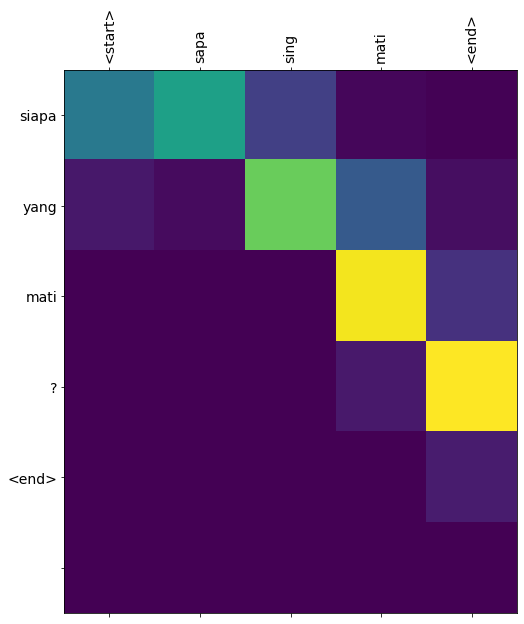

In [41]:
translate(u'sapa sing mati ' )